In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import EngFormatter
import scipy.signal as sp
rc('font',family='serif')
formatter0 = EngFormatter(unit='Hz')

In [2]:
file = open("data.bin", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()

In [3]:
I_data_raw = interleaved_data[0:len(interleaved_data):2]
Q_data_raw = interleaved_data[1:len(interleaved_data):2]

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

complex_data = I_samples + 1j*Q_samples

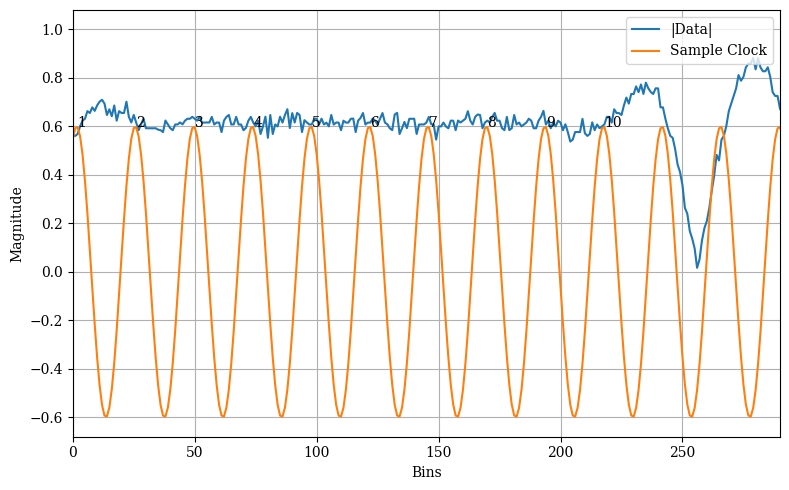

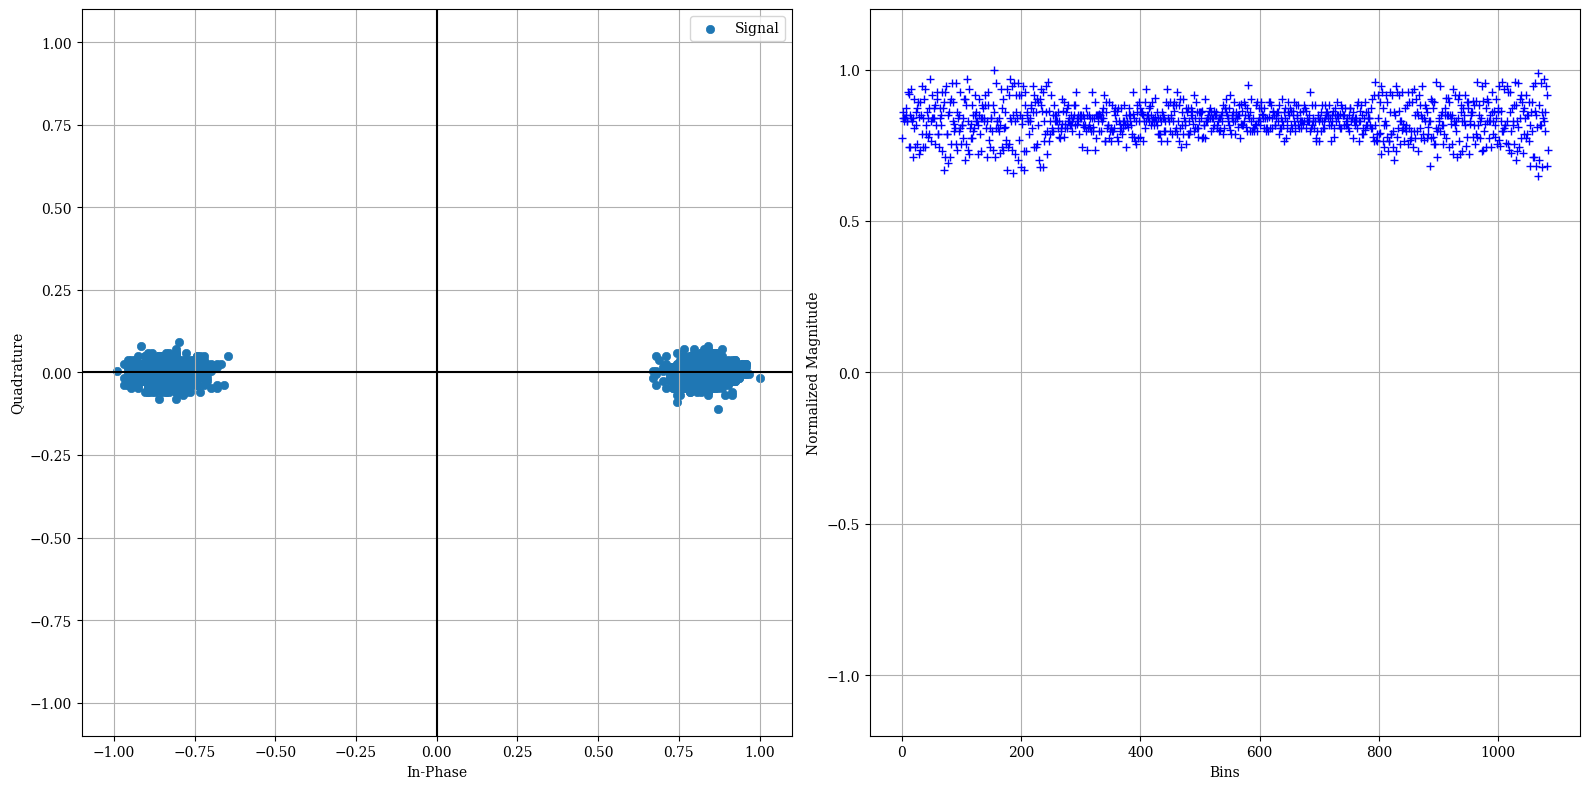

In [4]:
start = 73677
end = 99697
DATA_I = I_samples[start:end]
DATA_Q = Q_samples[start:end]
DATA_mag = np.abs(complex_data)[start:end]
DATA_I = DATA_I / DATA_mag.max()
DATA_Q = DATA_Q / DATA_mag.max()
DATA_signal = DATA_I + 1j*DATA_Q
fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples 
freq = np.fft.fftfreq(len(DATA_signal),dt)
bins=np.arange(0,len(DATA_signal),1)
t=bins*dt
DATA_SIGNAL_O = np.fft.fft(DATA_signal)
DATA_MAG_O = 10*np.log10(np.abs(DATA_SIGNAL_O))
Δ_Φ = np.diff(np.unwrap((np.angle(DATA_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
#print(" Corse Frequency Offset:",Δ_f,'Hz')
DATA_signal = DATA_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
DATA_SIGNAL = np.fft.fft(DATA_signal)
DATA_MAG = 10*np.log10(np.abs(DATA_SIGNAL))
DATA_SIGNAL_ABS = np.fft.fft(np.abs(DATA_signal))
DATA_MAG_ABS = 10*np.log10(np.abs(DATA_SIGNAL_ABS))
DATA_SIGNAL_Φ = np.angle(DATA_SIGNAL_ABS)
#Thus we obtain the frequency of the clock by lDBPSKing for the largest spike above the noise.
Index_max = 800+(DATA_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =DATA_SIGNAL_Φ[freq_bin]
#print('Clock Frequency:',f_clk,'Hz')
#print('Φ:',Φ,'radians')
#print('bin:',freq_bin)

Φ = DATA_SIGNAL_Φ[freq_bin]
f = freq[freq_bin]
ω = 2 * np.pi * f
NCO = np.cos((ω*t)+Φ) + 1j*np.sin((ω*t)+Φ)
NCO = NCO * (0.6)
global peak_bins 
peak_bins = sp.find_peaks(np.real(NCO))
symbol_data = []
for k in peak_bins[0]:
    symbol_data.append(DATA_signal[k])
sym_max = np.abs(symbol_data).max()
global norm_data
norm_data = np.real(symbol_data)/sym_max + 1j*np.imag(symbol_data)/sym_max
    

plt.rcParams['figure.figsize'] = (16,8)
freq_tick = np.arange(-1E8,1E8,200E3)

fig1, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)
ax.plot(bins,np.abs(DATA_signal),label="|Data|")
ax.plot(bins,np.real(NCO),label="Sample Clock")
ax.set_xlabel("Bins")
ax.set_ylabel("Magnitude")
ax.set_xlim(0,290)
for i in range(10):
    b = peak_bins[0][i]
    ax.annotate((i+1),(b,np.real(NCO[b])))
ax.legend(loc='upper right')
ax.grid()

fig2, (ax1, ax2) = plt.subplots(1, 2,tight_layout=True)
ax1.scatter(np.real(norm_data),np.imag(norm_data) ,linewidths=0.5,label='Signal')
ax1.set_xlabel("In-Phase")
ax1.set_ylabel("Quadrature")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.axhline(y=0,c='k')
ax1.axvline(x=0,c='k')
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(np.abs(norm_data),'b+')
ax2.set_xlabel("Bins")
ax2.set_ylim(-1.2,1.2)
ax2.set_ylabel("Normalized Magnitude")
ax2.grid()

# Carrier Synchronization DBPSK

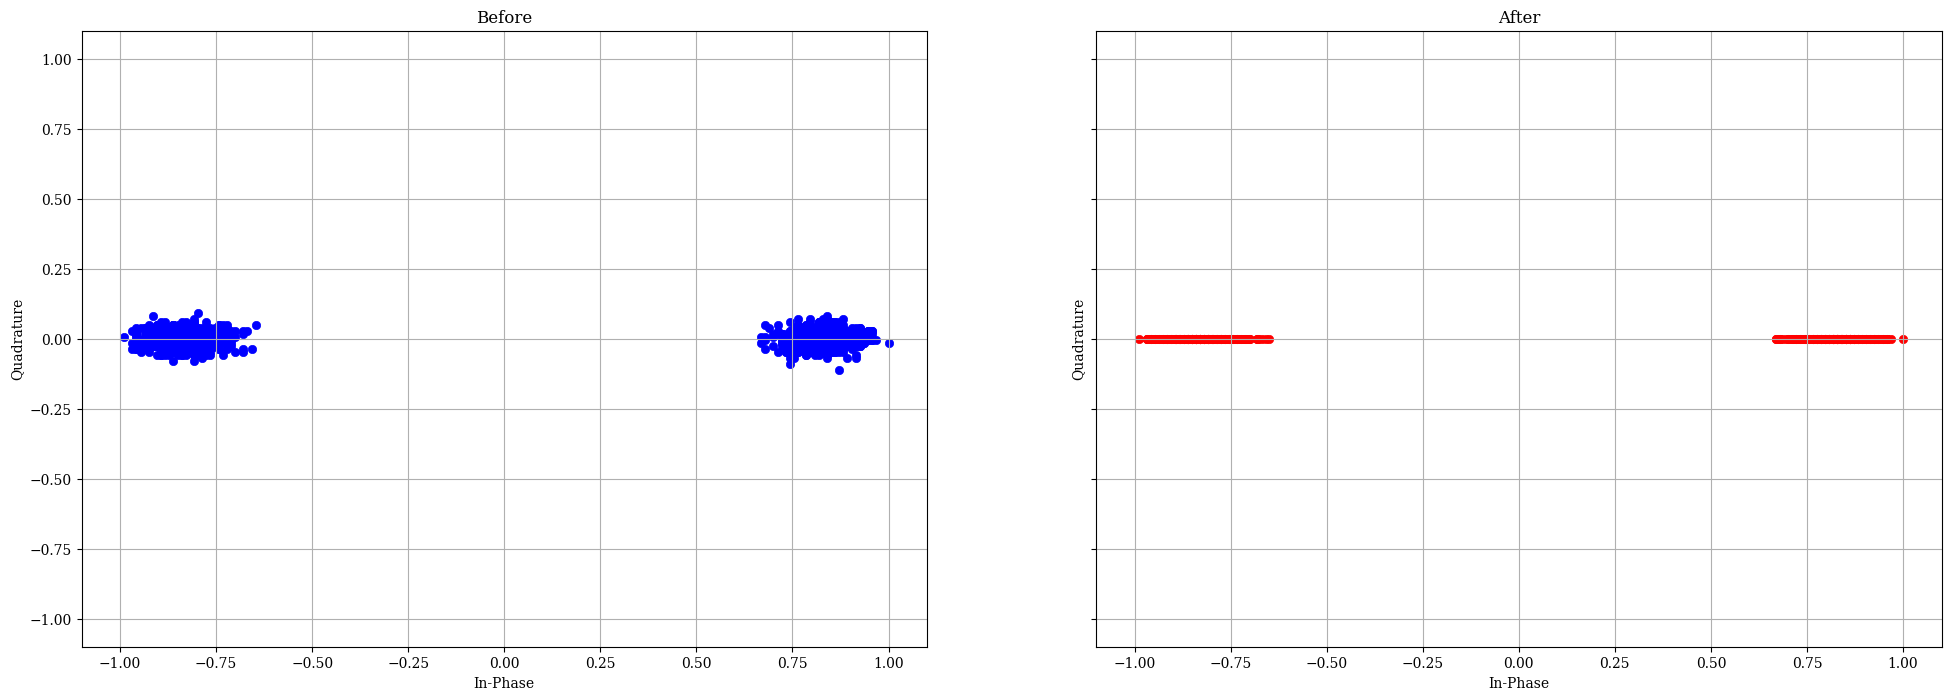

In [5]:
sd_after=[]
p0 = 1 + 1j*0
ΔΦ = 0
Φ_e = 0

Φ_error = []
Δ_Φ = []
for i in range (len(norm_data)):
    sd_after.append(norm_data[i])
    if i == 0:
        ΔΦ = np.angle(sd_after[i]*np.conj(p0))
        Φ_e += ΔΦ
    else:
        ΔΦ = np.angle(norm_data[i]*np.conj(norm_data[i-1]))
        if (np.pi/4) < np.abs(ΔΦ):
            Φ_e += (ΔΦ + np.pi)
        else:
            Φ_e += ΔΦ
    sd_after[i] = sd_after[i] * np.e**(-1j*Φ_e)
    Φ_error.append(Φ_e)
    Δ_Φ.append(ΔΦ)  
plt.rcParams['figure.figsize'] = (24,8)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.real(norm_data),np.imag(norm_data) ,linewidths=0.5,facecolors='b', edgecolors='b')
ax1.set_xlabel("In-Phase") 
ax1.set_ylabel("Quadrature")
ax1.set_title("Before")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.grid()
ax2.scatter(np.real(sd_after),np.imag(sd_after) ,linewidths=0.5,facecolors='r', edgecolors='r')
ax2.set_xlabel("In-Phase") 
ax2.set_ylabel("Quadrature")
ax2.set_title("After")
ax2.set_xlim(-1.1,1.1)
ax2.set_ylim(-1.1,1.1)
ax2.grid()
plt.show()

In [6]:
Δ_Φ = np.abs(np.diff((np.angle(sd_after,deg='True'))))
data = []
for i in range(len(Δ_Φ)):
    if 100 < Δ_Φ[i] < 260:
        data.append(1)
    else:
        data.append(0)
data = data[9:]

# Decoding Table

In [7]:
G = np.matrix([[1,0,0,0,1,1],
               [0,1,0,1,0,1],
               [0,0,1,1,1,1]])
print(G)

[[1 0 0 0 1 1]
 [0 1 0 1 0 1]
 [0 0 1 1 1 1]]


In [8]:
H = np.matrix([[0,1,1,1,0,0],
               [1,0,1,0,1,0],
               [1,1,1,0,0,1]])
HT = np.transpose(H)
print(H)
print('')
print(HT)

[[0 1 1 1 0 0]
 [1 0 1 0 1 0]
 [1 1 1 0 0 1]]

[[0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]]


In [9]:
E = np.matrix([[0,0,0,0,0,0],
               [1,0,0,0,0,0],
               [0,1,0,0,0,0],
               [0,0,1,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,0,1,0],
               [0,0,0,0,0,1],
               [0,0,0,1,1,0]])
Syndrome = np.mod((E@HT),2)
for i in range (8):
    print(E[i],Syndrome[i])

[[0 0 0 0 0 0]] [[0 0 0]]
[[1 0 0 0 0 0]] [[0 1 1]]
[[0 1 0 0 0 0]] [[1 0 1]]
[[0 0 1 0 0 0]] [[1 1 1]]
[[0 0 0 1 0 0]] [[1 0 0]]
[[0 0 0 0 1 0]] [[0 1 0]]
[[0 0 0 0 0 1]] [[0 0 1]]
[[0 0 0 1 1 0]] [[1 1 0]]


# Correction Code

In [10]:
corrected=[]
p = 0
print('Recieved data   syndrome    error  corrected   data')
for i in range(178):
    r = data[(i*6):(i+1)*6]
    syn = np.mod((r@HT),2)
    for j in range(8):
        if (np.array_equal(syn,Syndrome[j])):
            e = E[j]
            if (j !=0):
                p +=1
    c = r^e
    #print((r*1),(syn*1),(e*1),c*1)
    for k in range(3):
        if (c[0,k] == 1):
            corrected.append('1')
        else:
            corrected.append('0')
    print(r,syn,e,c,c[0,:3])

Recieved data   syndrome    error  corrected   data
[0, 1, 0, 1, 0, 0] [[0 0 1]] [[0 0 0 0 0 1]] [[0 1 0 1 0 1]] [[0 1 0]]
[0, 1, 1, 0, 0, 1] [[0 1 1]] [[1 0 0 0 0 0]] [[1 1 1 0 0 1]] [[1 1 1]]
[1, 0, 0, 0, 1, 0] [[0 0 1]] [[0 0 0 0 0 1]] [[1 0 0 0 1 1]] [[1 0 0]]
[1, 0, 0, 1, 0, 0] [[1 1 1]] [[0 0 1 0 0 0]] [[1 0 1 1 0 0]] [[1 0 1]]
[1, 1, 1, 0, 1, 0] [[0 1 1]] [[1 0 0 0 0 0]] [[0 1 1 0 1 0]] [[0 1 1]]
[1, 0, 0, 1, 0, 0] [[1 1 1]] [[0 0 1 0 0 0]] [[1 0 1 1 0 0]] [[1 0 1]]
[0, 0, 1, 1, 0, 0] [[0 1 1]] [[1 0 0 0 0 0]] [[1 0 1 1 0 0]] [[1 0 1]]
[0, 0, 0, 1, 0, 0] [[1 0 0]] [[0 0 0 1 0 0]] [[0 0 0 0 0 0]] [[0 0 0]]
[0, 1, 1, 1, 1, 0] [[1 0 0]] [[0 0 0 1 0 0]] [[0 1 1 0 1 0]] [[0 1 1]]
[0, 0, 0, 0, 1, 0] [[0 1 0]] [[0 0 0 0 1 0]] [[0 0 0 0 0 0]] [[0 0 0]]
[0, 1, 0, 1, 0, 1] [[0 0 0]] [[0 0 0 0 0 0]] [[0 1 0 1 0 1]] [[0 1 0]]
[1, 1, 0, 0, 0, 1] [[1 1 1]] [[0 0 1 0 0 0]] [[1 1 1 0 0 1]] [[1 1 1]]
[0, 1, 0, 1, 1, 1] [[0 1 0]] [[0 0 0 0 1 0]] [[0 1 0 1 0 1]] [[0 1 0]]
[0, 0, 0, 0, 1, 0] [[0 1 

In [11]:
corrected = ''.join(corrected)
message = ""
for i in  range(0,(67*8),8):
    temp_data = corrected[i:i + 8]
    print(temp_data)
    decimal_data = int(temp_data, 2) 
    message = message + chr(decimal_data)
print(message)

01011110
01010111
01101000
01100001
01110100
00100000
01100100
01101111
00100000
01111001
01101111
01110101
00100000
01100111
01100101
01110100
00100000
01110111
01101000
01100101
01101110
00100000
01111001
01101111
01110101
00100000
01100011
01110010
01101111
01110011
01110011
00100000
01100001
00100000
01101010
01101111
01101011
01100101
00100000
01110111
01101001
01110100
01101000
00100000
01100001
00100000
01110010
01101000
01100101
01110100
01101111
01110010
01101001
01100011
01100001
01101100
00100000
01110001
01110101
01100101
01110011
01110100
01101001
01101111
01101110
00111111
001001
^What do you get when you cross a joke with a rhetorical question?	
